In [12]:
import pandas as pd
import numpy as np
import geohash
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale

### Read the data

In [13]:
#taxidata=pd.read_csv("/Users/diana2/Dropbox/Spring2018Classes/DataSciIndustry/FinalProject/features.csv")
taxidata=pd.read_csv(r'C:\Users\diana\Dropbox\Spring2018Classes\DataSciIndustry\FInalProject/features.csv')

taxidata = taxidata.drop(taxidata.columns[0], axis=1)
taxidata = taxidata.drop(columns="pickup_datetime", axis=1)
taxidata = taxidata.drop(columns="date_of_year", axis=1)
taxidata = taxidata.drop(columns="Pickup Geohash", axis=1)
taxidata = taxidata.drop(columns="Dropoff Geohash", axis=1)
#taxidata = taxidata.drop(columns="distance_in_km", axis=1)
#print(taxidata.shape)
taxidata.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,travel_time,year,mo,da,temp,visib,...,day_of_week,weekday,day_binned,day_hour,time_binned,day_number,day_cosine,day_sine,time_cosine,time_sine
0,40.731525,-73.988670,40.760036,-73.984856,626,2016,1,18,27.1,8.9,...,1.0,1.0,0.142857,3.0,0.125000,0.160714,0.532032,0.846724,0.707107,0.707107
1,40.713608,-74.013718,40.765598,-73.980713,1192,2016,1,25,32.7,9.6,...,1.0,1.0,0.142857,17.0,0.708333,0.244048,0.037391,0.999301,-0.258819,-0.965926
2,40.773960,-73.874435,40.766693,-73.955414,842,2016,1,5,18.4,10.0,...,2.0,1.0,0.285714,0.0,0.000000,0.285714,-0.222521,0.974928,1.000000,0.000000
3,40.749718,-73.991570,40.768169,-73.912483,1054,2016,1,1,40.4,10.0,...,5.0,1.0,0.714286,7.0,0.291667,0.755952,0.037391,-0.999301,-0.258819,0.965926
4,40.762730,-73.974174,40.779640,-73.961823,538,2016,5,29,77.9,9.0,...,0.0,0.0,0.000000,14.0,0.583333,0.083333,0.866025,0.500000,-0.866025,-0.500000


### Extract and define training and testing data

In [33]:
X = taxidata.drop(["travel_time"], axis=1) # all rows, no label
Y = taxidata["travel_time"] # all rows, label only (travel_time)

#print(X.shape)
#print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

X_train = X_train.iloc[0:800000,:]
X_test = X_test.iloc[0:200000,:]
Y_train = Y_train.iloc[0:800000,]
Y_test = Y_test.iloc[0:200000,]

#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

### Cross Validation

In [63]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None, verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func, verbose=verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose=verbose)
    gs.fit(X, y)
    
    best = gs.best_estimator_
    return best

### Random Forest

In [37]:
from matplotlib import pyplot as plt
#Easy Random Forest
model = RandomForestRegressor(n_estimators=20, n_jobs=-1)
parameters = {"n_estimators": [50],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [50]}
best = cv_optimize(model, parameters, X_train, Y_train, n_folds=5, score_func='neg_mean_squared_error', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=50, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-75218.29599646099, total= 2.5min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-73750.14269067366, total= 2.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s


[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-75271.45250901688, total= 2.2min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-75296.84183691352, total= 2.2min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-74800.81302143802, total= 2.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.7min finished


### Evaluate the Results (contiguous with above code block)

In [40]:
# Fit the best Random Forest and calculate R^2 values for training and test sets
reg=best.fit(X_train, Y_train)
training_accuracy = reg.score(X_train, Y_train)
test_accuracy = reg.score(X_test, Y_test)
print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy))
print("R^2 on test data:     %0.4f" % (test_accuracy))

############# based on standard predict ################
R^2 on training data: 0.9677
R^2 on test data:     0.7799


In [43]:
# Calculate the Root Mean Squared Error
rmse = np.sqrt(sklearn.metrics.mean_squared_error(reg.predict(X_test),Y_test))
print("RMSE = %0.3f (this is in log-space!)" % rmse)
print("So two thirds of the records would be a factor of less than %0.2f away from the real value." % np.power(10,rmse))

RMSE = 271.080 (this is in log-space!)
So two thirds of the records would be a factor of less than 12019595507236507853347619142754399106861268087099559972628500454717956968880272379269178288612372734763370107124513437015366059331479781683003217600665453400485548259170603623087362238465498266018295340279845098017880980945856527538256050245541836478227256881519775449088.00 away from the real value.


### What are the most important features? 

In [44]:
# What are the most important features?
import operator
dict_feat_imp = dict(zip(list(X.columns.values),reg.feature_importances_))

sorted_features = sorted(dict_feat_imp.items(), key=operator.itemgetter(1), reverse=True)
sorted_features

[('distance_in_km', 0.6050026590932752),
 ('dropoff_latitude', 0.05713707334481019),
 ('pickup_longitude', 0.05119147573082785),
 ('dropoff_longitude', 0.050264870943778364),
 ('pickup_latitude', 0.04181589581412968),
 ('time_cosine', 0.02901557315573893),
 ('day_cosine', 0.01810780488141135),
 ('day_hour', 0.015027205520294287),
 ('time_binned', 0.013373097297582476),
 ('time_sine', 0.011911472711781562),
 ('wdsp', 0.011505733551526136),
 ('da', 0.011290129830904171),
 ('day_sine', 0.010053727338569674),
 ('temp', 0.008972744883201364),
 ('day_number', 0.008932628321444487),
 ('min', 0.00814277869807623),
 ('max', 0.007175072338710713),
 ('weekday', 0.006877571036317424),
 ('mo', 0.006851733093665959),
 ('gust', 0.006768602331087682),
 ('visib', 0.00654724222868589),
 ('prcp', 0.004939605011256528),
 ('sndp', 0.0031337221967517536),
 ('day_binned', 0.0018961663160417081),
 ('day_of_week', 0.0017060990677890743),
 ('rain_drizzle', 0.0012193081699795176),
 ('fog', 0.000645785252720676),

### Find optimal numer of estimators

Training R2, 10 estimators: 0.9555277370940122
Testing R2, 10 estimators: 0.7587428048917149
Training R2, 20 estimators: 0.9632315216696417
Testing R2, 20 estimators: 0.771309808356913
Training R2, 30 estimators: 0.9657130576996811
Testing R2, 30 estimators: 0.7764107892238256
Training R2, 40 estimators: 0.9669132145811213
Testing R2, 40 estimators: 0.778926524078088
Training R2, 50 estimators: 0.9676886073023269
Testing R2, 50 estimators: 0.7797394521762042
Training R2, 60 estimators: 0.9682688482967167
Testing R2, 60 estimators: 0.7812021505401445
Training R2, 70 estimators: 0.9685711282115411
Testing R2, 70 estimators: 0.7812638832389911
Training R2, 80 estimators: 0.9688139570568745
Testing R2, 80 estimators: 0.7817944486302382
Training R2, 90 estimators: 0.9690004760876215
Testing R2, 90 estimators: 0.7824383423143965
Training R2, 100 estimators: 0.9692133793596092
Testing R2, 100 estimators: 0.7824480813498644
Training R2, 110 estimators: 0.9693584210020774
Testing R2, 110 estima

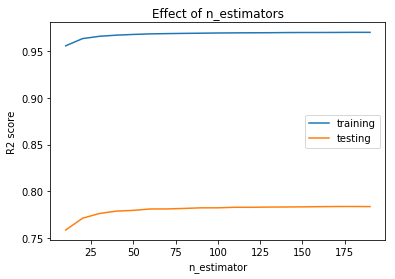

In [45]:
estimators = np.arange(10, 200, 10)
train_scores = []
test_scores = []
for n in estimators: 
    model.set_params(n_estimators=n)
    model.fit(X_train, Y_train)
    train_scores.append(model.score(X_train, Y_train))
    test_scores.append(model.score(X_test, Y_test))
    print("Training R2, {} estimators: {}".format(n, model.score(X_train, Y_train)))
    print("Testing R2, {} estimators: {}".format(n, model.score(X_test, Y_test)))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("R2 score")
plt.plot(estimators, train_scores, label="training")
plt.plot(estimators, test_scores, label="testing")
plt.legend()
plt.show()

Based on the above plot, we chose to use 50 estimators, because R2 score does not significantly increase after this point. 

### Reduce analysis to 10 most important features and 1 million datapoints

In [46]:
taxidata_10features = taxidata.drop(columns=['wdsp', 'da', 'day_sine', 'temp', 'day_number', 'min', 'max', 'weekday', 'mo', 'gust', 'visib', 'prcp', 'sndp', 'day_binned', 'day_of_week', 'rain_drizzle', 'fog', 'snow_ice_pellets', 'year', 'hail', 'thunder'])
X2 = taxidata_10features.drop(["travel_time"], axis=1) # all rows, no label
Y2 = taxidata_10features["travel_time"] # all rows, label only (travel_time)

#print(X.shape)
#print(Y.shape)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=42)
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

X_train2 = X_train2.iloc[0:800000,:]
X_test2 = X_test2.iloc[0:200000,:]
Y_train2 = Y_train2.iloc[0:800000,]
Y_test2 = Y_test2.iloc[0:200000,]

#from matplotlib import pyplot as plt
#Easy Random Forest
model2 = RandomForestRegressor(n_estimators=20, n_jobs=-1)
parameters2 = {"n_estimators": [50],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [50]}
best2 = cv_optimize(model2, parameters2, X_train2, Y_train2, n_folds=5, score_func='neg_mean_squared_error', verbose=3)

# Fit the best Random Forest and calculate R^2 values for training and test sets
reg2=best2.fit(X_train2, Y_train2)
training_accuracy2 = reg2.score(X_train2, Y_train2)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=50, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-79050.80442884615, total= 1.2min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-77853.7316232121, total= 1.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-79198.3716977557, total= 1.2min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-79751.52305289646, total= 1.2min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-78771.03002605702, total= 1.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.3min finished


NameError: name 'Y_test22' is not defined

In [47]:
test_accuracy2 = reg2.score(X_test2, Y_test2)
print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy2))
print("R^2 on test data:     %0.4f" % (test_accuracy2))

############# based on standard predict ################
R^2 on training data: 0.9659
R^2 on test data:     0.7666


## Drop distance_in_km (most important feature) to see what happens to R2 score

In [48]:
taxidata_9features = taxidata.drop(columns=['distance_in_km','wdsp', 'da', 'day_sine', 'temp', 'day_number', 'min', 'max', 'weekday', 'mo', 'gust', 'visib', 'prcp', 'sndp', 'day_binned', 'day_of_week', 'rain_drizzle', 'fog', 'snow_ice_pellets', 'year', 'hail', 'thunder'])
X3 = taxidata_9features.drop(["travel_time"], axis=1) # all rows, no label
Y3 = taxidata_9features["travel_time"] # all rows, label only (travel_time)

#print(X.shape)
#print(Y.shape)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, Y3, test_size=0.2, random_state=42)
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

X_train3 = X_train3.iloc[0:800000,:]
X_test3 = X_test3.iloc[0:200000,:]
Y_train3 = Y_train3.iloc[0:800000,]
Y_test3 = Y_test3.iloc[0:200000,]

#from matplotlib import pyplot as plt
#Easy Random Forest
model3 = RandomForestRegressor(n_estimators=20, n_jobs=-1)
parameters3 = {"n_estimators": [50],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [50]}
best3 = cv_optimize(model3, parameters3, X_train3, Y_train3, n_folds=5, score_func='neg_mean_squared_error', verbose=3)

# Fit the best Random Forest and calculate R^2 values for training and test sets
reg3=best3.fit(X_train3, Y_train3)
training_accuracy3 = reg3.score(X_train3, Y_train3)

test_accuracy3 = reg3.score(X_test3, Y_test3)
print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy3))
print("R^2 on test data:     %0.4f" % (test_accuracy3))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=50, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-77969.57491322793, total= 1.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-76620.09647597325, total= 1.2min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-78485.54941966369, total= 1.2min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-78537.83880137869, total= 1.2min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-77599.88632940265, total= 1.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished


############# based on standard predict ################
R^2 on training data: 0.9664
R^2 on test data:     0.7682


Interesting result, the R2 score is approximately the same without the distance_in_km feature, which was found to be the most important feature above. 

### Run Random forest with full dataset (3 million datapoints) and all features

In [50]:
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X, Y, test_size=0.2, random_state=42)
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

model4 = RandomForestRegressor(n_estimators=20, n_jobs=-1)
parameters4 = {"n_estimators": [50],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [50]}
best4 = cv_optimize(model4, parameters4, X_train4, Y_train4, n_folds=5, score_func='neg_mean_squared_error', verbose=3)

# Fit the best Random Forest and calculate R^2 values for training and test sets
reg4=best4.fit(X_train4, Y_train4)
training_accuracy4 = reg4.score(X_train4, Y_train4)

test_accuracy4 = reg4.score(X_test4, Y_test4)
print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy4))
print("R^2 on test data:     %0.4f" % (test_accuracy4))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=50, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-69106.08838904348, total= 8.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.9min remaining:    0.0s


[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-69333.50161390057, total= 8.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 17.3min remaining:    0.0s


[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-69709.45258552574, total= 8.0min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-69604.59026566047, total= 8.1min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-69197.92113248898, total= 8.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 42.4min finished


############# based on standard predict ################
R^2 on training data: 0.9702
R^2 on test data:     0.7955


In [72]:
#Output RMSE, RMSLE, R2
rmse = np.sqrt(sklearn.metrics.mean_squared_error(reg4.predict(X_test4),Y_test4))
print("RMSE = %0.3f (this is in log-space!)" % rmse)

rmsle = np.sqrt(sklearn.metrics.mean_squared_log_error(reg4.predict(X_test4),Y_test4))
print("RMSLE = %0.3f (this is in log-space!)" % rmsle)

RMSE = 261.041 (this is in log-space!)
RMSLE = 0.402 (this is in log-space!)


### Scale the input before fitting to get a reasonable RMSE/RMSLE

In [ ]:


X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X, Y, test_size=0.2, random_state=42)
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

model4 = RandomForestRegressor(n_estimators=20, n_jobs=-1)
parameters4 = {"n_estimators": [50],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [50]}

X_train4 = scale(X_train4)
X_test4 = scale(X_test4)
Y_train4 = scale(Y_train4)
Y_test4 = scale(Y_test4)

best4 = cv_optimize(model4, parameters4, X_train4, Y_train4, n_folds=5, score_func='neg_mean_squared_error', verbose=3)

# Fit the best Random Forest and calculate R^2 values for training and test sets
reg4=best4.fit(X_train4, Y_train4)
training_accuracy4 = reg4.score(X_train4, Y_train4)

test_accuracy4 = reg4.score(X_test4, Y_test4)
print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy4))
print("R^2 on test data:     %0.4f" % (test_accuracy4))

### Test on test dataset

In [ ]:
testing_data = pd.read_csv(r'C:\Users\diana\Dropbox\Spring2018Classes\DataSciIndustry\FInalProject\taxi_weather_data.csv')
testing_data = testing_data.drop(testing_data.columns[0], axis=1)
testing_data = testing_data.drop(columns="pickup_datetime", axis=1)
testing_data = testing_data.fillna(testing_data.mean())
predictions = reg4.predict(testing_data)


### Experiment with 9 features related to time, day, and geographical coordinates

In [64]:
X5 = taxidata[["time_binned", "time_cosine", "time_sine", "day_binned", "day_cosine", "day_sine", "weekday", "pickup_latitude", "pickup_longitude"]]
Y5 = taxidata["travel_time"] # all rows, label only (travel_time)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, Y5, test_size=0.2, random_state=42)
#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

model5 = RandomForestRegressor(n_estimators=20, n_jobs=-1)
parameters5 = {"n_estimators": [50],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [50]}
best5 = cv_optimize(model5, parameters5, X_train5, Y_train5, n_folds=5, score_func='neg_mean_squared_error', verbose=3)

# Fit the best Random Forest and calculate R^2 values for training and test sets
reg5=best5.fit(X_train5, Y_train5)
training_accuracy5 = reg5.score(X_train5, Y_train5)

test_accuracy5 = reg5.score(X_test5, Y_test5)
print("############# based on standard predict ################")
print("R^2 on training data: %0.4f" % (training_accuracy5))
print("R^2 on test data:     %0.4f" % (test_accuracy5))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=50, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-305420.4657434014, total= 3.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s


[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-306713.0368688267, total= 3.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.6min remaining:    0.0s


[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-307079.6969256474, total= 3.3min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-307441.01531783317, total= 3.1min
[CV] max_depth=50, max_features=auto, n_estimators=50 ................
[CV]  max_depth=50, max_features=auto, n_estimators=50, score=-306625.27105859807, total= 3.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.1min finished


############# based on standard predict ################
R^2 on training data: 0.8635
R^2 on test data:     0.0764


In [62]:
#Output RMSE, RMSLE, R2
rmse = np.sqrt(sklearn.metrics.mean_squared_error(reg5.predict(X_test5),Y_test5))
print("RMSE = %0.3f (this is in log-space!)" % rmse)

rmsle = np.sqrt(sklearn.metrics.mean_squared_log_error(reg5.predict(X_test5),Y_test5))
print("RMSLE = %0.3f (this is in log-space!)" % rmsle)

RMSE = 554.418 (this is in log-space!)
RMSE = 0.787 (this is in log-space!)


### Alternative approach testing: Random hyperparameter grid search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Following random hyperparameter grid search parameter choice, train with random search

In [22]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using five-fold cross validation, 
# search across 100 different combinations, and use all available cores
# Fit the random search model

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 88.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_sco

### Identify best parameters from random grid search

In [23]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

### Evaluate Random Search

In [25]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, Y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, Y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 217.2289 degrees.
Accuracy = 39.76%.
Model Performance
Average Error: 203.6144 degrees.
Accuracy = 47.66%.
Improvement of 19.89%.


### Based on results of random search, perform grid search with cross validation

In [31]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 70, 80, 90],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [50, 100, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

### Fit the model, display the best hyperparameters, evaluate performance

In [32]:
# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, Y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 114.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 278.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 509.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 585.1min finished


Model Performance
Average Error: 202.8605 degrees.
Accuracy = 48.17%.
Improvement of 21.18%.


We can see that the alternative method of random grid search had low performance compared to the final model chosen for this project. 